In [1]:
import torch
import triton
from kernels.softmax import softmax, softmax_per_row

## Softmax

### Unit test

In [2]:
DEVICE = triton.runtime.driver.active.get_active_torch_device()

torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE, dtype=torch.float32)
triton_y = softmax(x)
triton_y_per_row = softmax_per_row(x)
torch_y = torch.softmax(x, axis=1)
print(torch.max(torch.abs(triton_y - torch_y)))
print(torch.max(torch.abs(triton_y_per_row - torch_y)))

assert torch.allclose(triton_y, torch_y)
assert torch.allclose(triton_y_per_row, torch_y)

tensor(7.4506e-09, device='cuda:0')
tensor(7.4506e-09, device='cuda:0')


### Benchmark

In [3]:
def naive_softmax_2D(x):
    mx = torch.max(x, dim=-1, keepdim=True).values
    exp_x = torch.exp(x - mx)
    sum_exp_x = torch.sum(exp_x, dim=-1, keepdim=True)
    return exp_x / sum_exp_x

naive_y = naive_softmax_2D(x)
assert torch.allclose(naive_y, torch_y)

In [4]:
benchmark_config_col = triton.testing.Benchmark(
    x_names=['M'],
    x_vals=[128 * i for i in range(100, 1600, 20)],
    line_arg='provider',
    line_vals=['triton', 'torch', 'triton_per_row'],# 'naive'], 
    line_names=['Triton', 'Torch', 'Triton_per_row'],# 'Naive'],
    styles=[('blue', '-'), ('green', '-'), ('red', '-')],# ('orange', '-')],
    ylabel='GB/s',
    plot_name='Throughput of softmax',
    args={'N': 2048},    
)

In [5]:
@triton.testing.perf_report(benchmark_config_col)
def benchmark_col(M, N, provider): # name of args should be aligned with
                                     # 'x_names' and 'line_arg' in 'benchmark_config' function
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, dim=1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax(x, num_warps=8), quantiles=quantiles)
    if provider == 'triton_per_row':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax_per_row(x), quantiles=quantiles)

    # if provider == 'naive':
    #     ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax_2D(x), quantiles=quantiles)
    gb_per_s = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gb_per_s(ms), gb_per_s(max_ms), gb_per_s(min_ms)

In [6]:
# benchmark_col.run(print_data=False, show_plots=True)
# torch.cuda.empty_cache()


In [16]:
benchmark_config_row = triton.testing.Benchmark(
    x_names=['N'],
    x_vals=[64 * i for i in range(50, 240, 10)],
    line_arg='provider',
    line_vals=['triton', 'torch', 'triton_per_row'],# 'naive'], 
    line_names=['Triton', 'Torch', 'Triton_per_row'],# 'Naive'],
    styles=[('blue', '-'), ('green', '-'), ('red', '-')],# ('orange', '-')],
    ylabel='GB/s',
    plot_name='Throughput of softmax',
    args={'M': 100000},    
)

In [17]:
@triton.testing.perf_report(benchmark_config_row)
def benchmark_row(M, N, provider): # name of args should be aligned with
                                     # 'x_names' and 'line_arg' in 'benchmark_config' function
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, dim=1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax(x, num_warps=8), quantiles=quantiles)
    if provider == 'triton_per_row':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax_per_row(x), quantiles=quantiles)
    # if provider == 'naive':
    #     ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax_2D(x), quantiles=quantiles)
    gb_per_s = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gb_per_s(ms), gb_per_s(max_ms), gb_per_s(min_ms)

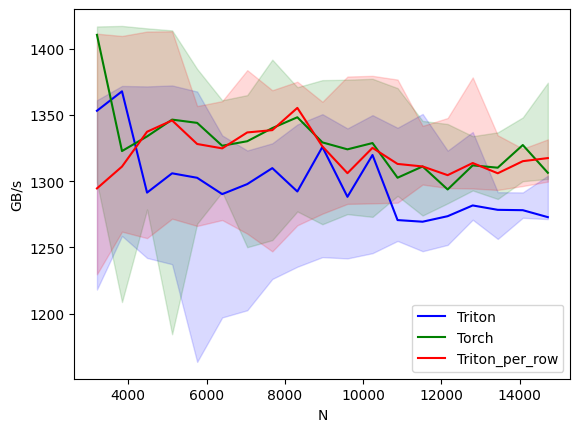

Throughput of softmax:
          N       Triton        Torch  Triton_per_row
0    3200.0  1353.195221  1410.536708     1294.547272
1    3840.0  1367.878627  1322.763475     1311.045548
2    4480.0  1291.373937  1333.809688     1337.345324
3    5120.0  1305.953662  1346.517977     1345.913873
4    5760.0  1302.570220  1344.048370     1328.102894
5    6400.0  1290.232415  1326.765844     1324.792089
6    7040.0  1297.804318  1330.182510     1336.827287
7    7680.0  1309.870862  1340.095851     1338.563623
8    8320.0  1292.211719  1348.282580     1355.366736
9    8960.0  1325.862230  1329.303294     1326.259950
10   9600.0  1288.198678  1324.062414     1306.060781
11  10240.0  1319.798515  1328.804798     1325.193476
12  10880.0  1270.628206  1302.615444     1313.041280
13  11520.0  1269.393545  1311.133049     1311.129135
14  12160.0  1273.565132  1293.745465     1304.556781
15  12800.0  1281.679855  1311.943220     1313.722382
16  13440.0  1278.370172  1310.200282     1305.978611
17  1

In [18]:
benchmark_row.run(print_data=True, show_plots=True)
torch.cuda.empty_cache()

